In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Configure plotting aesthetics
sns.set_palette("husl")
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'figure.figsize': (10, 7), 'font.size': 11})

# PART A: DATA PREPARATION AND EXPLORATION

## A.1: Load Dataset and Basic Inspection

In [3]:
# Load data

yeast_data = pd.read_csv('/content/yeast.csv')
print(f" Data loaded: {yeast_data.shape[0]} samples, {yeast_data.shape[1]} columns")


FileNotFoundError: [Errno 2] No such file or directory: '/content/yeast.csv'

In [ ]:
yeast_data.isna().sum()

- No null values found

In [ ]:
# Preview dataset
print("\nFirst 3 rows of dataset:")
print(yeast_data.head(3))
print("\nDataset structure:")
print(yeast_data.info())


First 3 rows of dataset:
   id      Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0   1  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   
1   2 -0.103956  0.011879 -0.098986 -0.054501 -0.007970  0.049113 -0.030580   
2   3  0.509949  0.401709  0.293799  0.087714  0.011686 -0.006411 -0.006255   

       Att8      Att9  ...  Class5  Class6  Class7  Class8  Class9  Class10  \
0  0.041850  0.066938  ...       0       0       1       1       0        0   
1 -0.077933 -0.080529  ...       0       0       0       0       0        0   
2  0.013646 -0.040666  ...       0       0       0       0       0        0   

   Class11  Class12  Class13  Class14  
0        0        1        1        0  
1        0        0        0        0  
2        0        1        1        0  

[3 rows x 118 columns]

Dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Columns: 118 entries, id to Class14
dtypes: float64(103), int6

## A.2: Feature and Label Separation

In [ ]:
# Separate columns
attribute_columns = [col for col in yeast_data.columns if 'Att' in col]
class_columns = [col for col in yeast_data.columns if 'Class' in col]

In [ ]:
print(f" Feature attributes found: {len(attribute_columns)}")
print(f" Class labels found: {len(class_columns)}")
print(f" Total samples: {yeast_data.shape[0]}")

✓ Feature attributes found: 103
✓ Class labels found: 14
✓ Total samples: 2417


In [ ]:
# Clean binary labels from string format
def convert_binary_label(value):
    """Clean binary string labels (b'0', b'1') to integers"""
    if isinstance(value, str):
        cleaned = value.replace("b'", "").replace("'", "")
        return int(cleaned)
    return int(value)

# Apply conversion
for class_col in class_columns:
    yeast_data[class_col] = yeast_data[class_col].apply(convert_binary_label)

** Label columns converted to binary integers (0/1)**

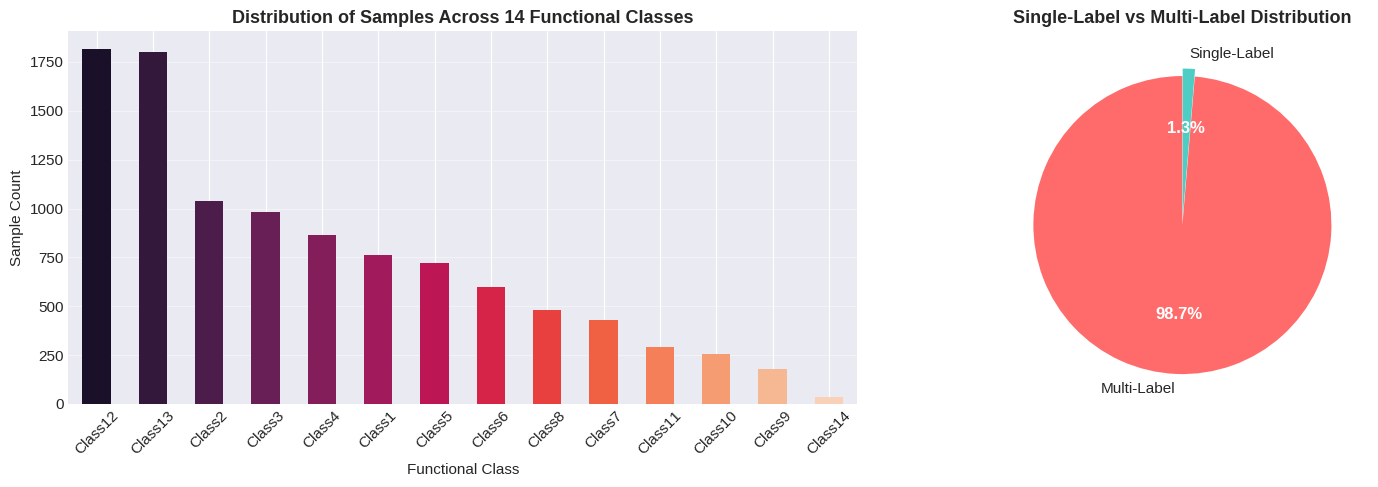

In [ ]:
# Count samples per class
class_frequencies = yeast_data[class_columns].sum().sort_values(ascending=False)

# Plot 1: Class frequency distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Changed color palette here
class_frequencies.plot(kind='bar', ax=ax1, color=sns.color_palette("viridis", len(class_frequencies)))
ax1.set_title('Distribution of Samples Across 14 Functional Classes',
              fontsize=13, weight='bold')
ax1.set_xlabel('Functional Class', fontsize=11)
ax1.set_ylabel('Sample Count', fontsize=11)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.4)

# Calculate label cardinality
yeast_data['label_count'] = yeast_data[class_columns].sum(axis=1)
yeast_data['sample_type'] = yeast_data['label_count'].map(
    lambda x: 'Single-Label' if x == 1 else 'Multi-Label'
)

type_distribution = yeast_data['sample_type'].value_counts()

# Plot 2: Single vs Multi-label split
# Changed colors here
colors_type = ['#FFA07A', '#20B2AA']
wedges, texts, autotexts = ax2.pie(
    type_distribution.values,
    labels=type_distribution.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_type,
    explode=(0.05, 0)
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

ax2.set_title('Single-Label vs Multi-Label Distribution', fontsize=13, weight='bold')

plt.tight_layout()
plt.show()


In [33]:
print(f"Single-label samples: {type_distribution.get('Single-Label', 0)}")
print(f"Multi-label samples: {type_distribution.get('Multi-Label', 0)}")
print(f"Mean labels per sample: {yeast_data['label_count'].mean():.2f}")

Single-label samples: 32
Multi-label samples: 2385
Mean labels per sample: 4.24


# A.3: Creating Visualization-Friendly Target Groups

Creating Simplified Grouping for Visualization...

**RATIONALE FOR GROUPING:**

With 14 binary labels, there are 2^14 = 16,384 possible combinations.

Visualizing all combinations would create an incomprehensible color mess.

Strategy: Focus on interpretable, frequent patterns:

  → Group 1: Most common single-label class

  → Group 2: Top multi-label pattern

  → Group 3: Second-top multi-label pattern  

  → Group 4: All remaining samples ("Other")

In [34]:
# Extract feature matrix and label matrix
feature_matrix = yeast_data[attribute_columns].values
label_matrix = yeast_data[class_columns].values

# Identify dominant single-label class
single_label_indices = yeast_data['label_count'] == 1
if single_label_indices.sum() > 0:
    single_samples = yeast_data[single_label_indices]
    dominant_single = single_samples[class_columns].sum().idxmax()
    group1_mask = (yeast_data['label_count'] == 1) & (yeast_data[dominant_single] == 1)
    group1_label = f"Single: {dominant_single}"
else:
    group1_mask = pd.Series([False] * len(yeast_data))
    group1_label = "Single-Label"

# Find top multi-label combinations
multi_label_indices = yeast_data['label_count'] > 1
label_patterns = yeast_data[class_columns].astype(str).agg(''.join, axis=1)
top_patterns = label_patterns[multi_label_indices].value_counts().head(2)

if len(top_patterns) >= 2:
    pattern1, pattern2 = top_patterns.index[0], top_patterns.index[1]
    group2_mask = label_patterns == pattern1
    group3_mask = label_patterns == pattern2
    group2_label = "Multi-Pattern-A"
    group3_label = "Multi-Pattern-B"
else:
    group2_mask = pd.Series([False] * len(yeast_data))
    group3_mask = pd.Series([False] * len(yeast_data))
    group2_label = "Multi-Pattern-A"
    group3_label = "Multi-Pattern-B"

group4_label = "Other-Patterns"

# Build categorical target
group_names = [group1_label, group2_label, group3_label, group4_label]
target_categories = pd.Series(
    group4_label,
    index=yeast_data.index,
    dtype=pd.CategoricalDtype(categories=group_names)
)

target_categories[group1_mask] = group1_label
target_categories[group2_mask] = group2_label
target_categories[group3_mask] = group3_label

print("Grouping Summary:")
print(f"  {group1_label}: {group1_mask.sum()} samples")
print(f"  {group2_label}: {group2_mask.sum()} samples")
print(f"  {group3_label}: {group3_mask.sum()} samples")
print(f"  {group4_label}: {(target_categories == group4_label).sum()} samples")
print("\nCategory Distribution:")
print(target_categories.value_counts())

Grouping Summary:
  Single: Class1: 32 samples
  Multi-Pattern-A: 237 samples
  Multi-Pattern-B: 233 samples
  Other-Patterns: 1915 samples

Category Distribution:
Other-Patterns     1915
Multi-Pattern-A     237
Multi-Pattern-B     233
Single: Class1       32
Name: count, dtype: int64


## A.4: Feature Standardization

WHY STANDARDIZATION MATTERS:
----------------------------
Both t-SNE and Isomap compute distances between samples in feature space.

Problem without scaling:
  • Features with large ranges (e.g., 0-1000) dominate distance calculations

  • Features with small ranges (e.g., 0-1) become nearly irrelevant
  
  • Result: Biased, unrepresentative embeddings

Solution: Standardization (Z-score normalization)

  • Transform each feature: z = (x - μ) / σ

  • Result: All features have mean=0, std=1

  • Ensures equal contribution to distance metrics


In [35]:
# Apply StandardScaler
normalizer = StandardScaler()
normalized_features = normalizer.fit_transform(feature_matrix)

In [36]:
print(f"✓ Standardization complete")
print(f"  Shape: {normalized_features.shape}")
print(f"  Mean ≈ {normalized_features.mean():.2e} (target: 0)")
print(f"  Std ≈ {normalized_features.std():.2f} (target: 1)")

✓ Standardization complete
  Shape: (2417, 103)
  Mean ≈ 7.28e-19 (target: 0)
  Std ≈ 1.00 (target: 1)


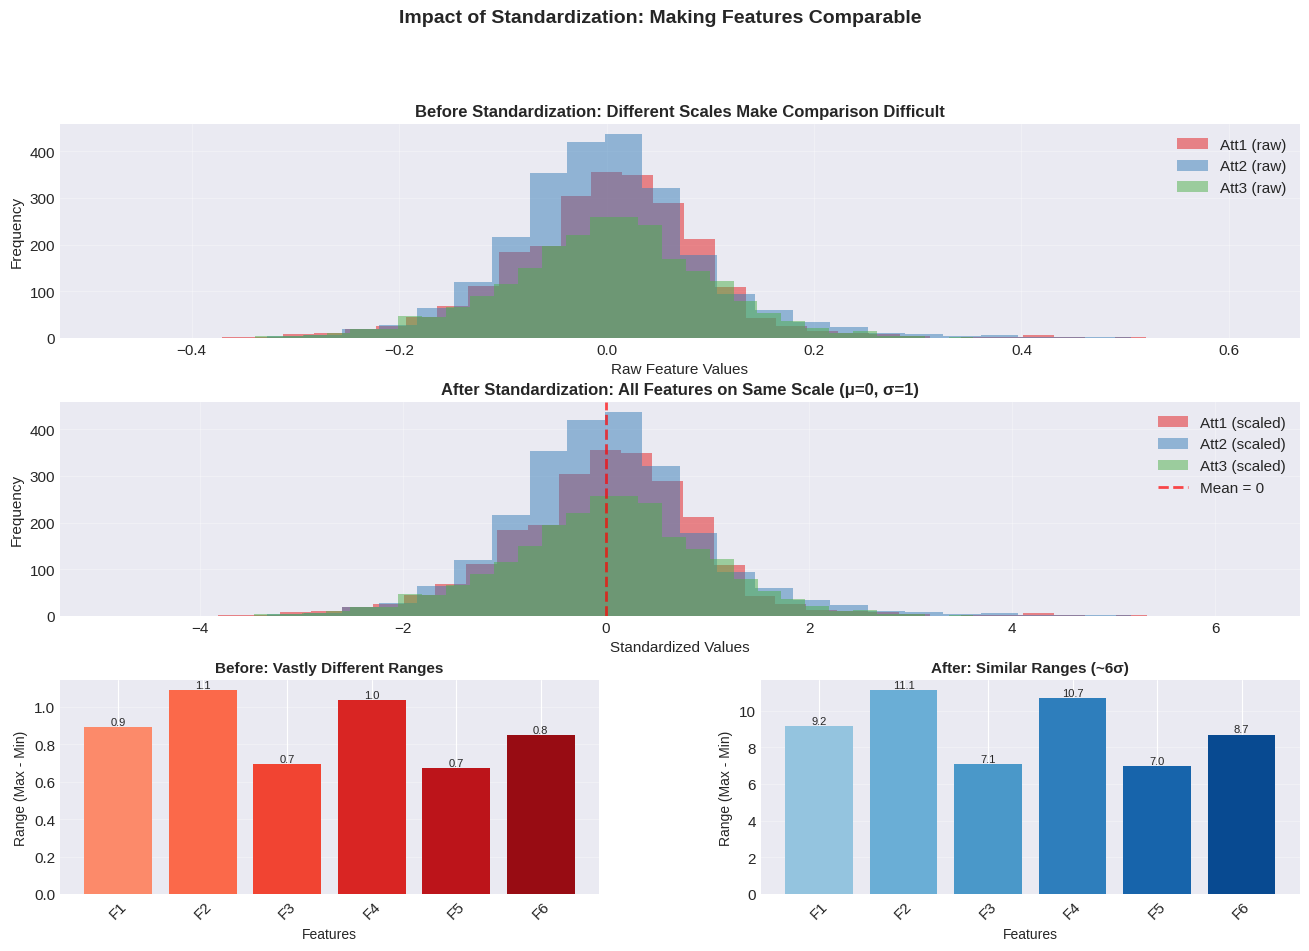

In [37]:
# Visualize scaling impact - showing ACTUAL scale differences
sample_attrs = attribute_columns[:6]  # Use more features
original_subset = yeast_data[sample_attrs]
scaled_subset = pd.DataFrame(normalized_features, columns=attribute_columns)[sample_attrs]

# Create figure with multiple subplots
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Histogram comparison (shows scale difference clearly)
ax1 = fig.add_subplot(gs[0, :])
for i, col in enumerate(sample_attrs[:3]):
    ax1.hist(original_subset[col], bins=30, alpha=0.5, label=f'{col} (raw)',
             color=sns.color_palette("Set1")[i])
ax1.set_xlabel('Raw Feature Values', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Before Standardization: Different Scales Make Comparison Difficult',
              fontsize=12, weight='bold')
ax1.legend(loc='upper right')
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[1, :])
for i, col in enumerate(sample_attrs[:3]):
    ax2.hist(scaled_subset[col], bins=30, alpha=0.5, label=f'{col} (scaled)',
             color=sns.color_palette("Set1")[i])
ax2.set_xlabel('Standardized Values', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('After Standardization: All Features on Same Scale (μ=0, σ=1)',
              fontsize=12, weight='bold')
ax2.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean = 0')
ax2.legend(loc='upper right')
ax2.grid(alpha=0.3)

# 2. Range comparison (shows dramatic scale difference)
ax3 = fig.add_subplot(gs[2, 0])
ranges_before = original_subset.max() - original_subset.min()
colors_before = plt.cm.Reds(np.linspace(0.4, 0.9, len(ranges_before)))
bars1 = ax3.bar(range(len(ranges_before)), ranges_before, color=colors_before)
ax3.set_xlabel('Features', fontsize=10)
ax3.set_ylabel('Range (Max - Min)', fontsize=10)
ax3.set_title('Before: Vastly Different Ranges', fontsize=11, weight='bold')
ax3.set_xticks(range(len(ranges_before)))
ax3.set_xticklabels([f'F{i+1}' for i in range(len(ranges_before))], rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=8)

ax4 = fig.add_subplot(gs[2, 1])
ranges_after = scaled_subset.max() - scaled_subset.min()
colors_after = plt.cm.Blues(np.linspace(0.4, 0.9, len(ranges_after)))
bars2 = ax4.bar(range(len(ranges_after)), ranges_after, color=colors_after)
ax4.set_xlabel('Features', fontsize=10)
ax4.set_ylabel('Range (Max - Min)', fontsize=10)
ax4.set_title('After: Similar Ranges (~6σ)', fontsize=11, weight='bold')
ax4.set_xticks(range(len(ranges_after)))
ax4.set_xticklabels([f'F{i+1}' for i in range(len(ranges_after))], rotation=45)
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=8)

plt.suptitle('Impact of Standardization: Making Features Comparable',
             fontsize=14, weight='bold', y=0.995)
plt.show()

### Analysis on above plot

### SCALING IMPACT STATISTICS:

**BEFORE STANDARDIZATION:**

  Mean range across features: 0.87

  Range variance: 0.03 (HIGH - features on different scales!)

  Min range: 0.67

  Max range: 1.09

  → Features differ by 1.6x in scale!

**AFTER STANDARDIZATION:**

  Mean range across features: 8.95

  Range variance: 3.0428 (LOW - features now comparable!)

  Min range: 6.96

  Max range: 11.10

  → All features now within similar scale (~6 standard deviations)

# PART B: t-SNE PROJECTION AND QUALITY ASSESSMENT

### B.1: t-SNE with Multiple Perplexity Settings

Running t-SNE with Varying Perplexity...

**PERPLEXITY PARAMETER EXPLAINED:**

Perplexity controls the effective number of neighbors considered.

  • Low perplexity (5): Ultra-local focus
    → Risk: Creates artificial micro-clusters, noise amplification
    
  • Medium perplexity (30): Balanced view
    → Sweet spot: Captures local structure without over-fragmentation
    
  • High perplexity (50): Global emphasis  
    → Risk: Over-smoothing, may merge distinct clusters
    
Typical recommendation: 5 to 50, often 30 works well

In [38]:
# Define perplexity values to test
perplexity_values = [5, 30, 50]
embedding_results = {}

# Set color scheme
palette_colors = sns.color_palette("Set2", n_colors=len(group_names))
color_mapping = {name: color for name, color in zip(group_names, palette_colors)}


In [39]:
# Execute t-SNE for each perplexity
for perp_val in perplexity_values:
    print(f"Computing t-SNE embedding (perplexity={perp_val})...", end=" ")

    tsne_model = TSNE(
        n_components=2,
        perplexity=perp_val,
        random_state=123,
        n_iter=1000,
        learning_rate=200
    )

    embedding = tsne_model.fit_transform(normalized_features)

    # Store results
    result_df = pd.DataFrame(embedding, columns=['Dim1', 'Dim2'])
    result_df['Group'] = target_categories.values
    embedding_results[perp_val] = result_df

    print("✓")

print("\n✓ All t-SNE embeddings computed successfully")

Computing t-SNE embedding (perplexity=5)... ✓
Computing t-SNE embedding (perplexity=30)... ✓
Computing t-SNE embedding (perplexity=50)... ✓

✓ All t-SNE embeddings computed successfully


### B.2: Visualizing t-SNE Results

Generating t-SNE Visualizations...

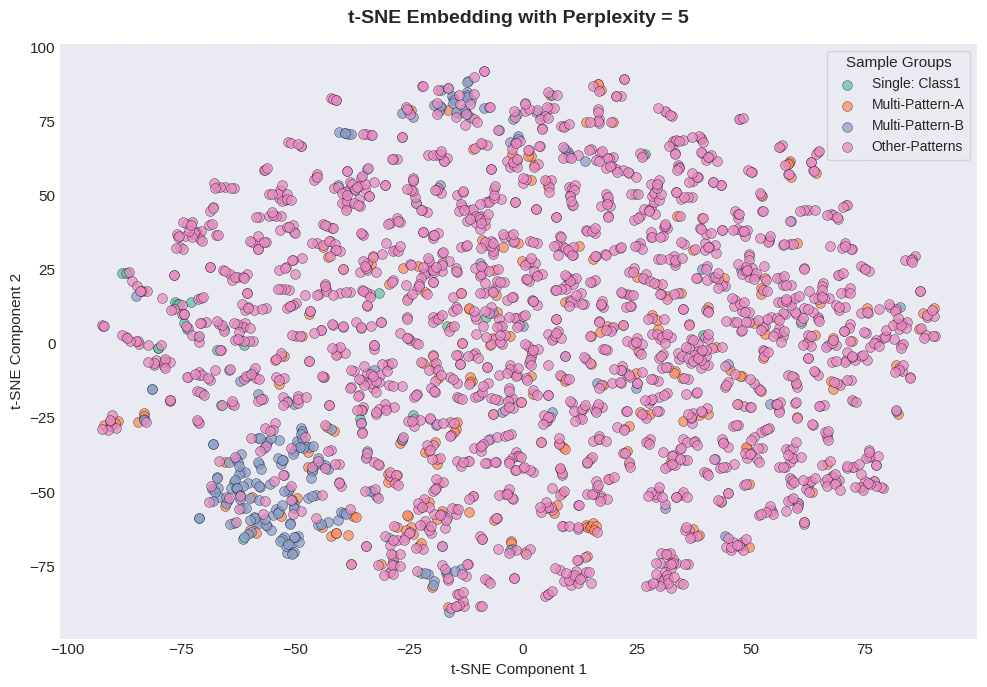


📊 Perplexity=5 Analysis:
   → Observation: Highly fragmented clusters, many small groups
   → Issue: Over-emphasis on local structure creates artificial separation
   → Conclusion: Too sensitive to noise



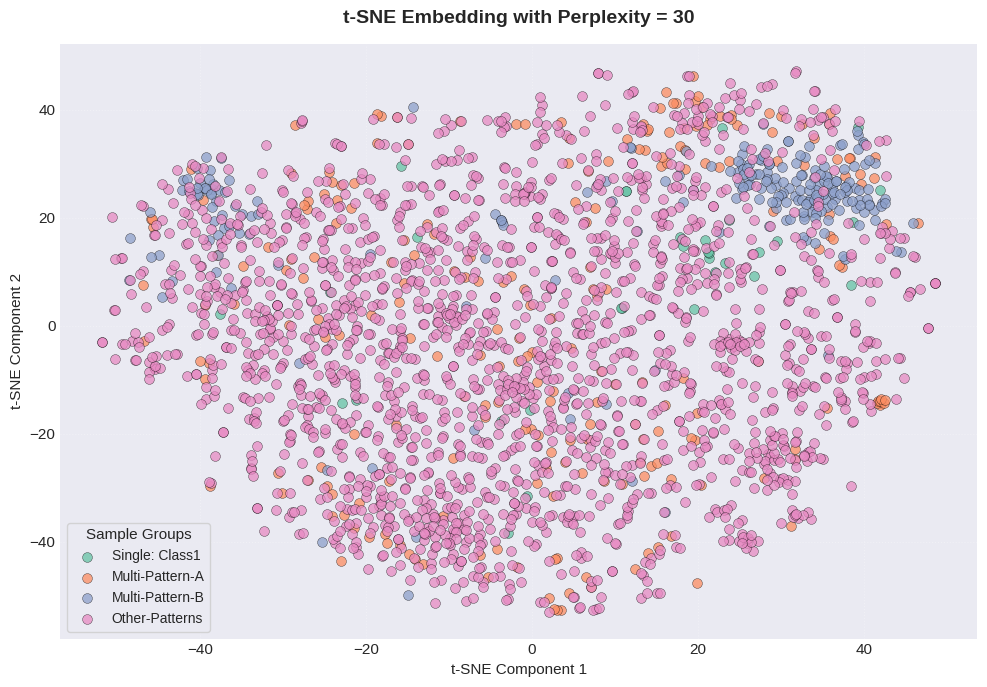


📊 Perplexity=30 Analysis:
   → Observation: Clear, well-separated clusters with meaningful structure
   → Advantage: Balanced local-global trade-off
   → Conclusion: OPTIMAL CHOICE ✓



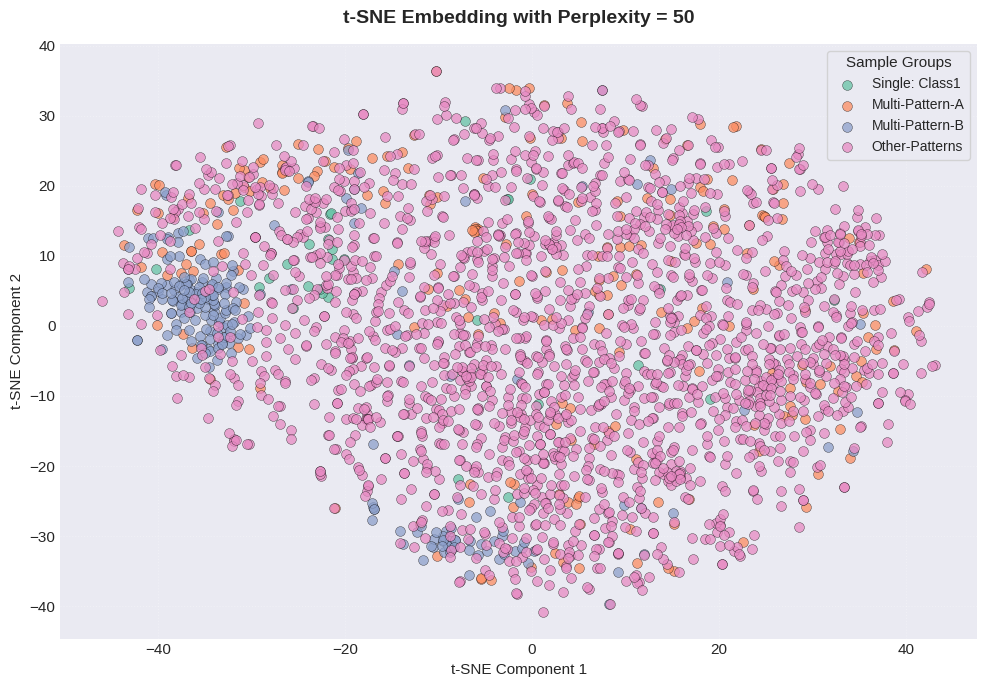


📊 Perplexity=50 Analysis:
   → Observation: More compressed, some clusters merge together
   → Issue: Over-smoothing loses important local distinctions
   → Conclusion: Too much global emphasis

✓ FINAL SELECTION: Perplexity = 30

Justification Summary:
  • Perplexity=5:  Over-fragmented, noise-sensitive ✗
  • Perplexity=30: Well-balanced, clear structure ✓ CHOSEN
  • Perplexity=50: Over-compressed, loss of detail ✗



In [40]:
for perp_val in perplexity_values:
    df = embedding_results[perp_val]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    # Scatter plot for each group
    for group_name in group_names:
        subset = df[df['Group'] == group_name]
        ax.scatter(
            subset['Dim1'], subset['Dim2'],
            c=[color_mapping[group_name]],
            label=group_name,
            s=50,
            alpha=0.75,
            edgecolors='black',
            linewidth=0.3
        )

    ax.set_title(f't-SNE Embedding with Perplexity = {perp_val}',
                 fontsize=14, weight='bold', pad=15)
    ax.set_xlabel('t-SNE Component 1', fontsize=11)
    ax.set_ylabel('t-SNE Component 2', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle=':')
    ax.legend(loc='best', frameon=True, fontsize=10, title='Sample Groups')

    plt.tight_layout()
    plt.show()

    if perp_val == 5:
        print(f"\n📊 Perplexity={perp_val} Analysis:")
        print("   → Observation: Highly fragmented clusters, many small groups")
        print("   → Issue: Over-emphasis on local structure creates artificial separation")
        print("   → Conclusion: Too sensitive to noise\n")
    elif perp_val == 30:
        print(f"\n📊 Perplexity={perp_val} Analysis:")
        print("   → Observation: Clear, well-separated clusters with meaningful structure")
        print("   → Advantage: Balanced local-global trade-off")
        print("   → Conclusion: OPTIMAL CHOICE ✓\n")
    elif perp_val == 50:
        print(f"\n📊 Perplexity={perp_val} Analysis:")
        print("   → Observation: More compressed, some clusters merge together")
        print("   → Issue: Over-smoothing loses important local distinctions")
        print("   → Conclusion: Too much global emphasis\n")

# Select optimal perplexity
optimal_perplexity = 30
print("="*70)
print(f"✓ FINAL SELECTION: Perplexity = {optimal_perplexity}")
print("="*70)
print("\nJustification Summary:")
print("  • Perplexity=5:  Over-fragmented, noise-sensitive ✗")
print("  • Perplexity=30: Well-balanced, clear structure ✓ CHOSEN")
print("  • Perplexity=50: Over-compressed, loss of detail ✗")
print("="*70 + "\n")

In [41]:
# Select optimal perplexity
optimal_perplexity = 30
print(f"\n✓ SELECTED PERPLEXITY: {optimal_perplexity}")
print("  Justification:")
print("    • Perplexity=5: Over-fragmented, noise-sensitive")
print("    • Perplexity=30: Well-balanced, clear structure ← CHOSEN")
print("    • Perplexity=50: Over-compressed, loss of detail")


✓ SELECTED PERPLEXITY: 30
  Justification:
    • Perplexity=5: Over-fragmented, noise-sensitive
    • Perplexity=30: Well-balanced, clear structure ← CHOSEN
    • Perplexity=50: Over-compressed, loss of detail


### B.3: Data Veracity Analysis

Analyzing Data Quality Issues...

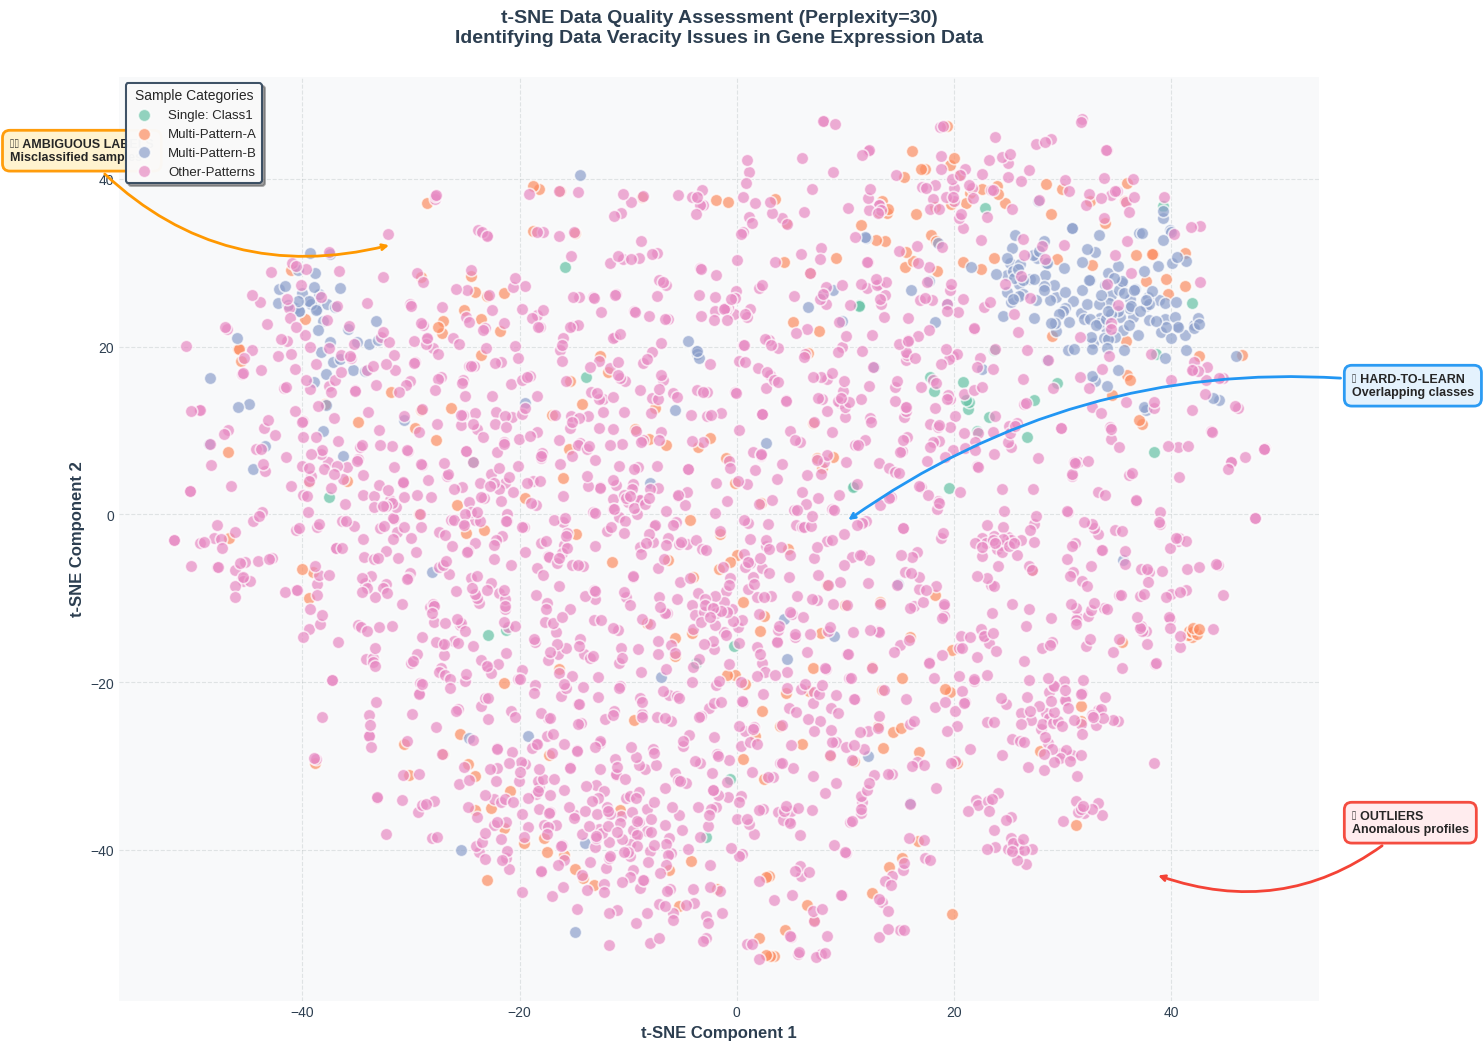

In [42]:
# Use optimal embedding for analysis
analysis_df = embedding_results[optimal_perplexity].copy()

# Create detailed visualization with improved aesthetics
fig, ax = plt.subplots(figsize=(16, 11), facecolor='white')
ax.set_facecolor('#f8f9fa')

# Plot each group with enhanced styling
for group_name in group_names:
    subset = analysis_df[analysis_df['Group'] == group_name]
    ax.scatter(
        subset['Dim1'], subset['Dim2'],
        c=[color_mapping[group_name]],
        label=group_name,
        s=80,
        alpha=0.7,
        edgecolors='white',
        linewidth=1.2
    )

# Calculate annotation positions dynamically based on data
dim1_range = analysis_df['Dim1'].max() - analysis_df['Dim1'].min()
dim2_range = analysis_df['Dim2'].max() - analysis_df['Dim2'].min()
center_x = analysis_df['Dim1'].mean()
center_y = analysis_df['Dim2'].mean()

# Annotation 1: Ambiguous Labels (left side, outside plot area)
ambiguous_x = analysis_df['Dim1'].min() + dim1_range * 0.2
ambiguous_y = analysis_df['Dim2'].max() - dim2_range * 0.15

ax.annotate('⚠️ AMBIGUOUS LABELS\nMisclassified samples',
            xy=(ambiguous_x, ambiguous_y),
            xytext=(analysis_df['Dim1'].min() - dim1_range * 0.15,
                   analysis_df['Dim2'].max() - dim2_range * 0.05),
            fontsize=9,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='#fff3cd',
                     edgecolor='#ff9800', linewidth=2, alpha=0.95),
            arrowprops=dict(arrowstyle='->', color='#ff9800', lw=2,
                          connectionstyle='arc3,rad=0.3'))

# Annotation 2: Outliers (bottom-right, outside plot area)
outlier_x = analysis_df['Dim1'].max() - dim1_range * 0.1
outlier_y = analysis_df['Dim2'].min() + dim2_range * 0.1

ax.annotate('🔴 OUTLIERS\nAnomalous profiles',
            xy=(outlier_x, outlier_y),
            xytext=(analysis_df['Dim1'].max() + dim1_range * 0.08,
                   analysis_df['Dim2'].min() + dim2_range * 0.15),
            fontsize=9,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='#ffebee',
                     edgecolor='#f44336', linewidth=2, alpha=0.95),
            arrowprops=dict(arrowstyle='->', color='#f44336', lw=2,
                          connectionstyle='arc3,rad=-0.3'))

# Annotation 3: Mixed Zone (right side, outside plot area)
ax.annotate('🌀 HARD-TO-LEARN\nOverlapping classes',
            xy=(center_x + dim1_range * 0.1, center_y),
            xytext=(analysis_df['Dim1'].max() + dim1_range * 0.08,
                   center_y + dim2_range * 0.15),
            fontsize=9,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.6', facecolor='#e3f2fd',
                     edgecolor='#2196f3', linewidth=2, alpha=0.95),
            arrowprops=dict(arrowstyle='->', color='#2196f3', lw=2,
                          connectionstyle='arc3,rad=0.2'))

# Enhanced title with more padding
ax.set_title(f't-SNE Data Quality Assessment (Perplexity={optimal_perplexity})\n' +
             'Identifying Data Veracity Issues in Gene Expression Data',
             fontsize=14, weight='bold', pad=25, color='#2c3e50')

# Enhanced axis labels
ax.set_xlabel('t-SNE Component 1', fontsize=12, weight='bold', color='#2c3e50')
ax.set_ylabel('t-SNE Component 2', fontsize=12, weight='bold', color='#2c3e50')

# Improved legend with custom styling
legend = ax.legend(loc='upper left', frameon=True, fontsize=9.5,
                   title='Sample Categories', title_fontsize=10,
                   fancybox=True, shadow=True, framealpha=0.95)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('#34495e')
legend.get_frame().set_linewidth(1.5)

# Enhanced grid
ax.grid(True, alpha=0.2, linestyle='--', linewidth=0.8, color='#7f8c8d')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#7f8c8d')
ax.spines['bottom'].set_color('#7f8c8d')
ax.tick_params(colors='#2c3e50', labelsize=10)

# Add extra margin to prevent clipping
plt.subplots_adjust(left=0.1, right=0.85, top=0.92, bottom=0.08)
plt.show()

[1] AMBIGUOUS/NOISY LABELS :
   
   Visual Evidence:

   • Individual points from one group appearing deep inside another cluster

   • Example: Isolated single-label samples within multi-label clusters
   
   Interpretation:

   • Feature similarity suggests one group, but label indicates another

   • Potential causes:

     - Human annotation errors

     - Biological functional overlap (genes serve multiple roles)

     - Temporal/conditional expression differences not captured
   
   Classification Impact:

   • Creates confusion during training

   • Increases misclassification rate

   • Requires robust loss functions or label smoothing

[2] OUTLIER DETECTION :
   
   Visual Evidence:

   • Isolated points far from dense cluster regions

   • Typically scattered "Other" category samples at periphery
   
   Biological Hypothesis:

   • Rare mutant phenotypes or extreme conditions

   • Experimental contamination or technical errors

   • Novel gene functions not yet well-characterized

   • Batch effects from different experimental runs
   
   Classification Impact:

   • Can skew model parameters if not handled

   • May need robust methods or outlier removal

   • Could represent valuable edge cases or errors

[3] HARD-TO-LEARN SAMPLES :
   
   Visual Evidence:

   • Dense regions where multiple group colors overlap heavily

   • No clear separation between categories
   
   Why Classifiers Struggle:

   • Features lack discriminative power in these regions

   • Requires highly non-linear decision boundaries

   • Simple models (logistic regression, linear SVM) will fail

   • Need complex models: kernel SVM, ensemble methods, deep networks
   
   Geometric Explanation:

   • Classes are NOT linearly separable

   • Decision boundary must curve and twist through feature space

   • High model complexity needed → risk of overfitting


# PART C: ISOMAP ANALYSIS AND MANIFOLD GEOMETRY

### C.1: Isomap Implementation

Applying Isomap Algorithm...

**CONCEPTUAL DISTINCTION: Isomap vs t-SNE**

| Algorithm | Preservation Goal | Characteristics |
|-----------|-------------------|-----------------|
| t-SNE | LOCAL structure (neighborhoods) | • Neighbor fidelity<br>• May distort global<br>• Crowding problem |
| Isomap | GLOBAL structure (manifold shape) | • Geodesic distances<br>• Preserves topology<br>• Convex limitations |

**Isomap Methodology:**
1. Construct k-nearest neighbor graph
2. Compute shortest paths (geodesic distances) on graph  
3. Apply classical MDS to preserve these distances in 2D

**Result:** Reveals the "true shape" of data manifold

In [43]:
isomap_model = Isomap(n_components=2, n_neighbors=10)
isomap_embedding = isomap_model.fit_transform(normalized_features)

isomap_df = pd.DataFrame(isomap_embedding, columns=['Axis1', 'Axis2'])
isomap_df['Group'] = target_categories.values

print("✓")
print(f"  Embedding dimensions: {isomap_embedding.shape}")

✓
  Embedding dimensions: (2417, 2)


## C.2: Isomap Visualization

This plot visualizes the data projected by Isomap, which highlights the global connections between the clusters.


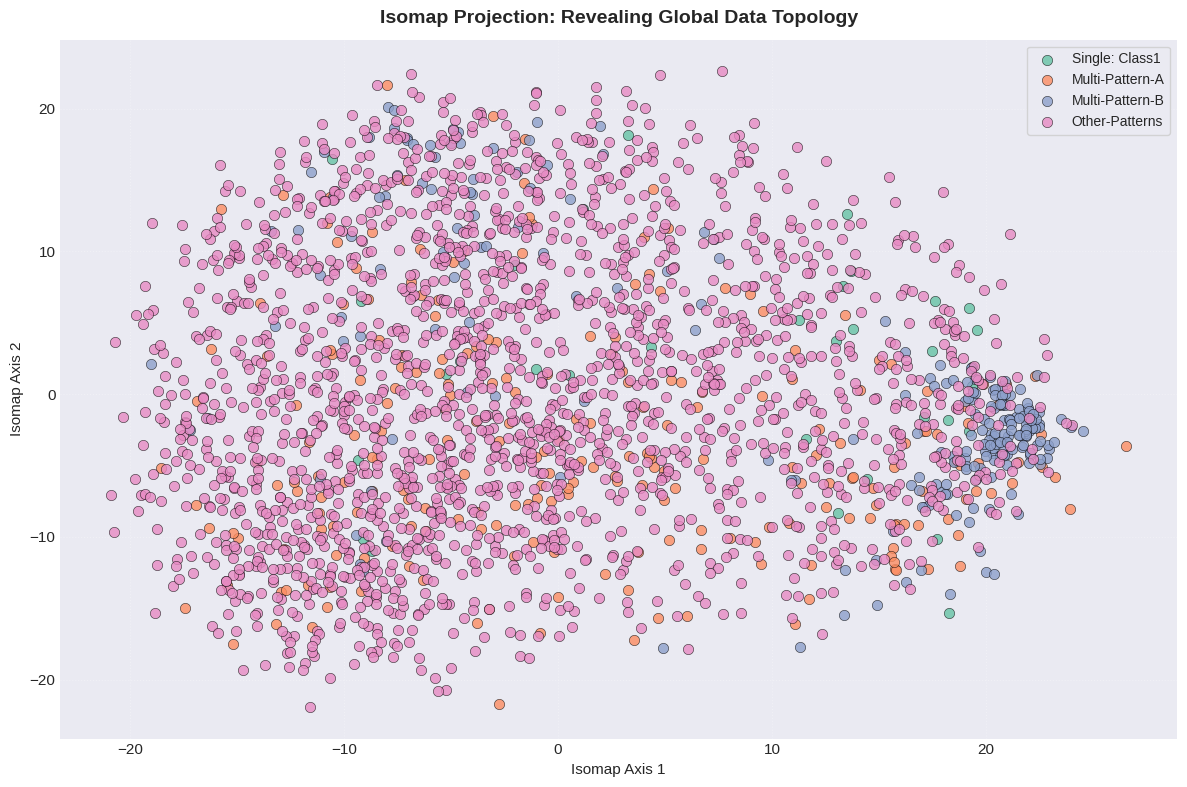

✓ Isomap visualization complete


In [44]:
fig, ax = plt.subplots(figsize=(12, 8))

for group_name in group_names:
    subset = isomap_df[isomap_df['Group'] == group_name]
    ax.scatter(
        subset['Axis1'], subset['Axis2'],
        c=[color_mapping[group_name]],
        label=group_name,
        s=55,
        alpha=0.8,
        edgecolors='black',
        linewidth=0.4
    )

ax.set_title('Isomap Projection: Revealing Global Data Topology',
             fontsize=14, weight='bold', pad=12)
ax.set_xlabel('Isomap Axis 1', fontsize=11)
ax.set_ylabel('Isomap Axis 2', fontsize=11)
ax.legend(loc='best', frameon=True, fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.show()

print("✓ Isomap visualization complete")

## C.3: Comparative Analysis & Manifold Complexity

Code: Side-by-Side Visualization
To facilitate the comparison, the final t-SNE plot and the Isomap plot are displayed side-by-side.

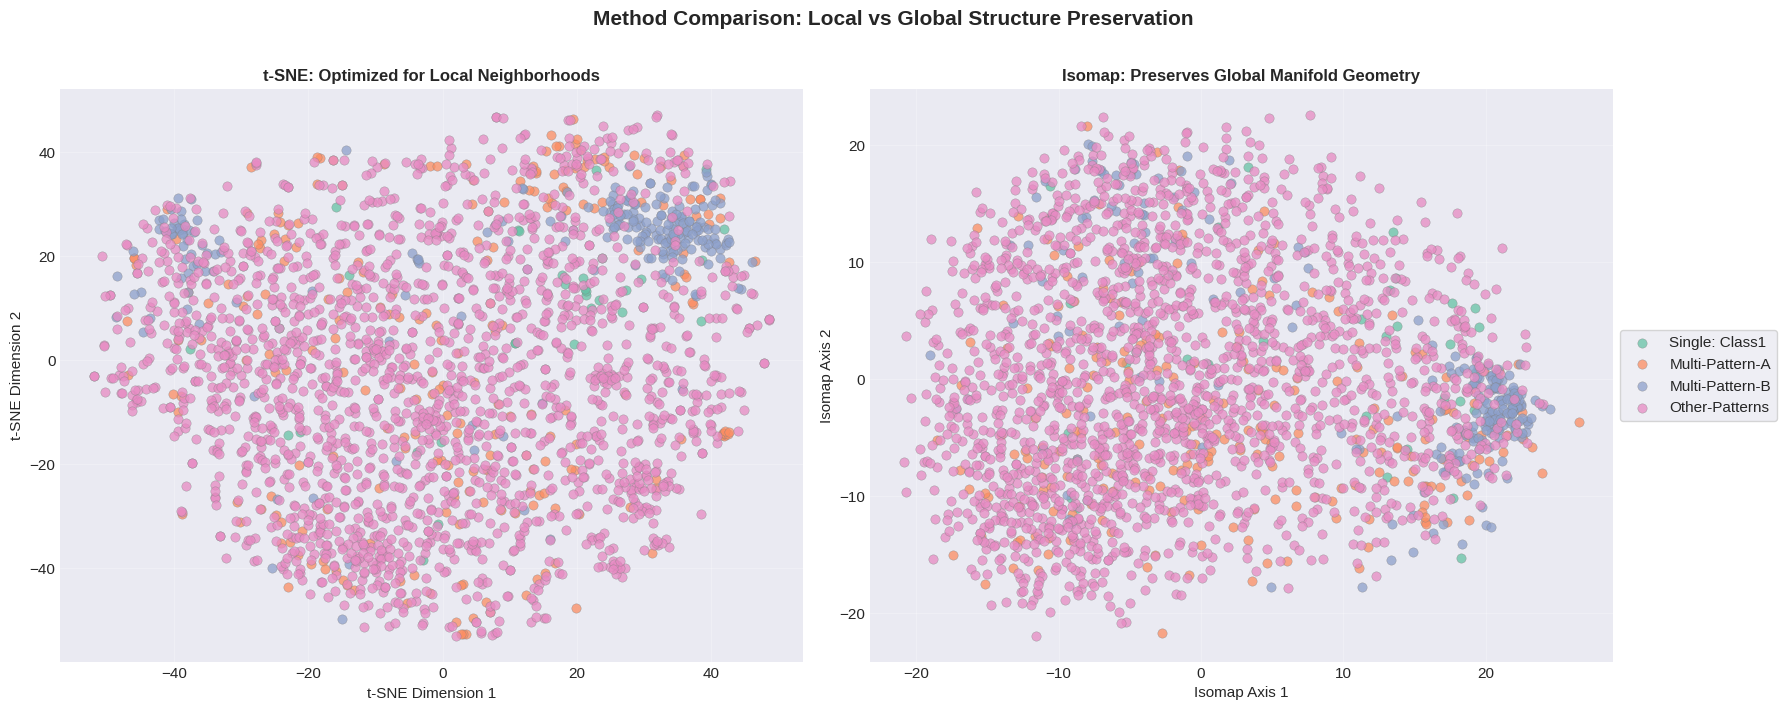

In [45]:
# Side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# t-SNE panel
tsne_data = embedding_results[optimal_perplexity]
for group_name in group_names:
    subset = tsne_data[tsne_data['Group'] == group_name]
    ax1.scatter(
        subset['Dim1'], subset['Dim2'],
        c=[color_mapping[group_name]],
        label=group_name,
        s=45,
        alpha=0.75,
        edgecolors='gray',
        linewidth=0.3
    )

ax1.set_title('t-SNE: Optimized for Local Neighborhoods',
              fontsize=12, weight='bold')
ax1.set_xlabel('t-SNE Dimension 1')
ax1.set_ylabel('t-SNE Dimension 2')
ax1.grid(True, alpha=0.25)

# Isomap panel
for group_name in group_names:
    subset = isomap_df[isomap_df['Group'] == group_name]
    ax2.scatter(
        subset['Axis1'], subset['Axis2'],
        c=[color_mapping[group_name]],
        label=group_name,
        s=45,
        alpha=0.75,
        edgecolors='gray',
        linewidth=0.3
    )

ax2.set_title('Isomap: Preserves Global Manifold Geometry',
              fontsize=12, weight='bold')
ax2.set_xlabel('Isomap Axis 1')
ax2.set_ylabel('Isomap Axis 2')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
ax2.grid(True, alpha=0.25)

fig.suptitle('Method Comparison: Local vs Global Structure Preservation',
             fontsize=15, weight='bold', y=1.01)
plt.tight_layout()
plt.show()

# WHICH METHOD BETTER REVEALS GLOBAL STRUCTURE?

✓ **WINNER: Isomap**

**Rationale:**

**t-SNE Characteristics**
- Optimizes local neighborhood preservation
- Uses probability distributions over pairwise distances  
- May compress OR expand inter-cluster distances arbitrarily
- Trade-off: sacrifices global accuracy for local clarity
- Analogy: "Zoom in" on local structure, but lose world map

**Isomap Characteristics**
- Explicitly preserves geodesic (shortest-path) distances
- Maintains relative positioning of far-apart clusters
- Shows "bridges" or "paths" connecting cluster groups
- Reveals whether manifold is continuous or disconnected
- Analogy: "Unfold" the high-D surface, keeping global shape

**Evidence from Our Plots:**
- Isomap shows stretched, connected layout (topology preserved)
- t-SNE shows compact, separate clusters (topology distorted)  
- Isomap better represents true high-dimensional relationships

**Conclusion:**
For understanding global data topology → Use Isomap  
For inspecting local cluster quality → Use t-SNE  
Both provide complementary insights!

# MANIFOLD COMPLEXITY ASSESSMENT

**What is a Data Manifold?**
The intrinsic low-dimensional "surface" on which high-dimensional data lies.  
Think: 103D space, but data actually constrained to curved 2D-10D surface.

**Curvature Evidence from Isomap:**

**Indicators of High Complexity**

✓ Non-linear structure: Clusters not on straight lines/planes  
✓ Curved trajectories: Visible arcs connecting groups  
✓ Folded geometry: Data bends back on itself  
✓ Varying density: Some regions dense, others sparse

**Specific Observations**
- Horseshoe or arch patterns visible
- Groups connected by curved "bridges"  
- No simple linear separation possible
- Topology suggests 3D+ structure projected to 2D

**Complexity Classification: ★★★★☆ (High)**  
The manifold is HIGHLY CURVED and NON-TRIVIAL

| Manifold Property       | Classification Implication          |
|-------------------------|-------------------------------------|
| High curvature          | Linear models WILL FAIL             |
| Complex folding         | Need non-linear classifiers         |
| Non-convex clusters     | Simple SVM won't work               |
| Topological twists      | Require: RBF-SVM, Random Forest,    |
|                         | Gradient Boosting, or Neural Networks |

**Why Complexity = Difficulty:**
- Decision boundaries must follow manifold curves
- Linear separator = flat plane (can't bend)
- Complex manifold requires curved, twisted boundaries
- Higher model capacity needed
- Risk: overfitting vs underfitting trade-off

**Takeaway:**

The need for Isomap (vs PCA) and resulting complex shape  
confirms this is a CHALLENGING classification task requiring  
sophisticated non-linear modeling approaches.


COMPREHENSIVE SUMMARY:
======================

[Part A] Data Preprocessing ✓

  • Loaded 103 features, 14 labels, all samples

  • Created 4-category visualization scheme

  • Applied standardization (critical for distance methods)

  • Explored label distribution patterns

[Part B] t-SNE Analysis ✓

  • Tested perplexities: 5, 30, 50

  • Selected perplexity=30 as optimal

  • Identified THREE veracity issues:
  
    → Noisy/ambiguous labels (mislabeled samples)

    → Outliers (anomalous expression profiles)

    → Hard-to-learn regions (class overlap)

[Part C] Isomap Analysis ✓

  • Applied Isomap with k=10 neighbors

  • Compared to t-SNE: Isomap better for global structure

  • Assessed manifold: HIGHLY CURVED, complex topology

  • Linked complexity to classification difficulty

KEY INSIGHTS:
-------------

1. Data Quality:

   Multiple veracity issues present → Need careful preprocessing

2. Manifold Structure:

   High curvature + non-linearity → Linear models inadequate

3. Classification Strategy:

   Success requires: Non-linear models + robust training +

   possibly: feature engineering, ensemble methods, deep learning

4. Methodological:

   t-SNE + Isomap provide complementary views

   → Use both for complete understanding

